In [ ]:
import boto3
import sagemaker
from sagemaker.session import Session
from sagemaker import get_execution_role
from sagemaker.serializers import CSVSerializer
from sagemaker.image_uris import retrieve
from sagemaker.session import TrainingInput

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import io, os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## Get data type to train model

In [ ]:
supported_data_type = ('genomic', 'genomic-clinical', 'genomic-clinical-imaging')
#data_type = 'genomic'
#data_type = 'genomic-clinical'
data_type = 'genomic-clinical-imaging'

## Set up S3 buckets and session

In [ ]:
sm_session = sagemaker.Session()
bucket = sm_session.default_bucket()
region = boto3.Session().region_name
role = get_execution_role()

boto_session = boto3.Session(region_name=region)
sagemaker_client = boto_session.client(service_name='sagemaker', region_name=region)
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

s3_client = boto3.client('s3', region_name=region)

default_s3_bucket_name = sm_session.default_bucket()
prefix = 'multi-model-health-ml'

## Get features from SageMaker FeatureStore based on data type

In [ ]:
from sagemaker.feature_store.feature_group import FeatureGroup

genomic_feature_group_name = 'genomic-feature-group'
clinical_feature_group_name = 'clinical-feature-group'
imaging_feature_group_name = 'imaging-feature-group'

genomic_feature_group = FeatureGroup(name=genomic_feature_group_name, sagemaker_session=feature_store_session)
clinical_feature_group = FeatureGroup(name=clinical_feature_group_name, sagemaker_session=feature_store_session)
imaging_feature_group = FeatureGroup(name=imaging_feature_group_name, sagemaker_session=feature_store_session)

In [ ]:
genomic_query = genomic_feature_group.athena_query()
clinical_query = clinical_feature_group.athena_query()
imaging_query = imaging_feature_group.athena_query()

genomic_table = genomic_query.table_name
clinical_table = clinical_query.table_name
imaging_table = imaging_query.table_name

print('Table names')
print(genomic_table)
print(clinical_table)
print(imaging_table)

In [ ]:
def get_features(data_type, output_location):  
    if (data_type == 'genomic'):
        query_string = f'SELECT * FROM "{genomic_table}"'
        print(query_string)
        genomic_query.run(query_string=query_string, output_location=output_location)
        genomic_query.wait()
        dataset = genomic_query.as_dataframe()
 
        # Drop features
        l_drop = ['case_id', 'pathologicalmstage', 'eventtime', 'write_time', 'api_invocation_time', 'is_deleted'] 
        dataset = dataset.drop(l_drop, axis = 1) 
        
    elif (data_type == 'genomic-clinical'):
        query_string = f'''SELECT * FROM "{clinical_table}"
                           LEFT JOIN "{genomic_table}" ON "{clinical_table}".case_id = "{genomic_table}".case_id'''
        print(query_string)

        genomic_query.run(query_string=query_string, output_location=output_location)
        genomic_query.wait()
        dataset = genomic_query.as_dataframe()
        
        # Drop features
        l_drop = ['case_id', 'case_id.1', 'survival_status', 'pathologicalmstage', 
                  'eventtime', 'write_time', 'api_invocation_time', 'is_deleted',
                  'eventtime.1', 'write_time.1', 'api_invocation_time.1', 'is_deleted.1']
        dataset = dataset.drop(l_drop, axis = 1)
        
    elif (data_type == 'genomic-clinical-imaging'):
        query_string = f'''SELECT "{genomic_table}".*, "{clinical_table}".*, "{imaging_table}".* 
                           FROM "{genomic_table}"
                               LEFT OUTER JOIN "{clinical_table}" ON "{clinical_table}".case_id = "{genomic_table}".case_id
                               LEFT OUTER JOIN "{imaging_table}" ON "{clinical_table}".case_id = "{imaging_table}".subject
                           ORDER BY "{clinical_table}".case_id ASC'''
        print(query_string)
        
        genomic_query.run(query_string=query_string, output_location=output_location)
        genomic_query.wait()
        dataset = genomic_query.as_dataframe()
        
        # Drop features
        l_drop = ['case_id', 'case_id.1', 'survival_status', 'pathologicalmstage', 
                  'eventtime', 'write_time', 'api_invocation_time', 'is_deleted',
                  'eventtime.1', 'write_time.1', 'api_invocation_time.1', 'is_deleted.1', 
                  'eventtime.2', 'write_time.2', 'api_invocation_time.2', 'is_deleted.2']
        l_drop_img = ['imagename', 'maskname', 'scandate', 'subject']
        l_drop_img += [i for i in dataset.columns.tolist() if 'diagnostics' in i]
        
        dataset = dataset.drop(l_drop + l_drop_img, axis = 1)
        
        
    elif data_type not in supported_data_type:
        raise KeyError(f'data_type {data_type} is not supported for this analysis.')
        
    return dataset

In [ ]:
fs_output_location = f's3://{default_s3_bucket_name}/{prefix}/feature-store-queries'
dataset = get_features(data_type, fs_output_location)

# Write to csv in S3 without headers and index column.
filename=f'{data_type}-dataset.csv'
dataset_uri_prefix = f's3://{default_s3_bucket_name}/{prefix}/training_input/';

dataset.to_csv(filename, header=False, index=False)
s3_client.upload_file(filename, default_s3_bucket_name, f'{prefix}/training_input/{filename}')

In [ ]:
X = dataset.drop(['survivalstatus'], axis =1)
y = dataset['survivalstatus']

# %% Clearing NaNs and replacing with zeros
X.fillna(value=0., inplace=True)
## use pandas.fillna because the following two lines throw TypeError
## TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely 
## coerced to any supported types according to the casting rule ''safe''
# loc_nan = np.where(np.isnan(X)) 
# X.iloc[loc_nan] = 0.

print ('Number of samples in multimodal data: ',dataset.shape[0])
print ('Number of features in multimodal data: ',dataset.shape[1])

## Split data for training and testing

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Scale features

In [ ]:
# Add Feature Scaling
sc = StandardScaler()
sc.fit(X_trainval)
X_trainval_scaled = sc.transform(X_trainval)
X_test_scaled = sc.transform(X_test)

## Get feature importance

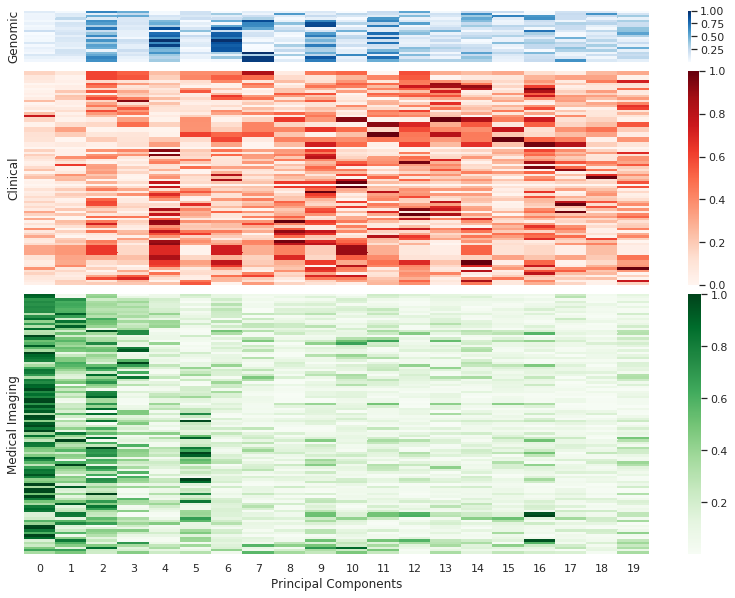

In [19]:
# Get column header for visualization
header = dataset.columns.values

sns.set(rc={'figure.figsize':(14,10)})

names = list(header)
names = names[1:]

# PCA and feature importance
# Indices depend on the above join operation on multiple tables  
indices = {'imaging': 108, 'clinical': 21}

# Set variance threshold for PCA to 99%
pca_threshold = 0.99
pca = PCA(n_components = pca_threshold)
X_trainval_pca = pca.fit_transform(X_trainval_scaled)
features_projected = abs(pca.components_).T
fn = MinMaxScaler().fit_transform(features_projected*pca.explained_variance_ratio_)

# Select top 20 PCs to plot
n_pc = 20
fn = fn[:,:n_pc]

fn_genomic = fn[0:indices['clinical'], :]
fn_clinical = fn[indices['clinical']:indices['imaging'], :]
fn_imaging = fn[indices['imaging']:, :]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, gridspec_kw={'wspace':0.025, 'hspace':0.052, 'height_ratios': [indices['clinical'], indices['imaging']-indices['clinical']+1, X.shape[1]-indices['imaging']]})

sns.heatmap(fn_genomic, ax=ax1, xticklabels=False, yticklabels=False, cmap="Blues", cbar=True)
sns.heatmap(fn_clinical, ax=ax2, xticklabels=False, yticklabels=False, cmap="Reds", cbar=True)
sns.heatmap(fn_imaging, ax=ax3, yticklabels=False, cmap="Greens", cbar=True)
ax3.set_xlabel('Principal Components')
ax3.set_ylabel('Medical Imaging')
ax2.set_ylabel('Clinical')
ax1.set_ylabel('Genomic')
plt.subplots_adjust(wspace=None, hspace=None)
plt.savefig('pca_matrix.png', dpi=450, bbox_inches='tight')

## Plot Correlation Circle 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


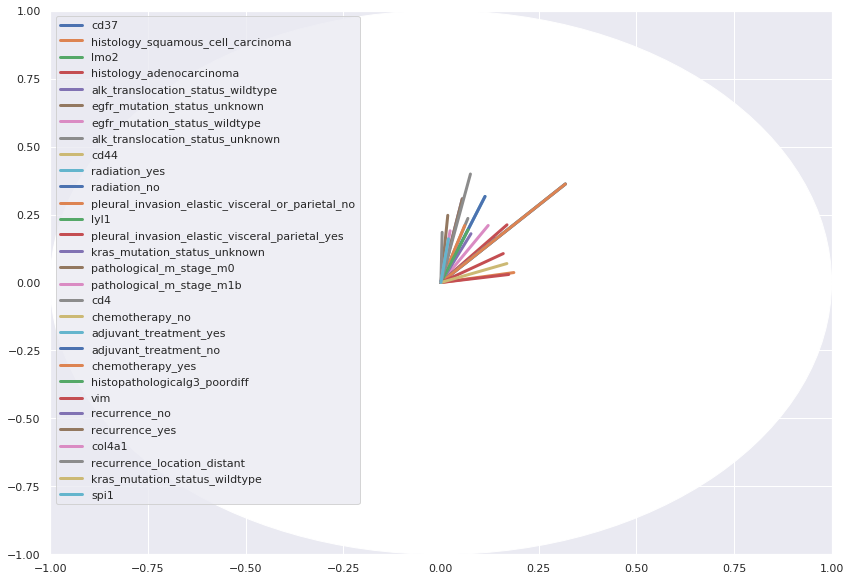

<Figure size 1008x720 with 0 Axes>

In [20]:
fig = plt.figure()
# Principal components to plot
pc_n1 = 4
pc_n2 = 5
r = np.linalg.norm(fn[:,pc_n1:pc_n2], axis=1)

ix_r = np.argsort(-r)
# Select top 30 features
top_r = 30
for i in range(top_r):
    plt.plot([0, fn[ix_r[i],0]], [0, fn[ix_r[i],1]], lw=3., label=names[ix_r[i]])

temp = np.max(r)
ax = fig.add_subplot(1, 1, 1)
circ = plt.Circle((0, 0), radius=temp, edgecolor=None, facecolor='w')
ax.add_patch(circ)

plt.xlim([-temp, temp])
plt.ylim([-temp, temp])
plt.legend()
plt.show()
plt.savefig('correlationcircle.png', dpi=300, bbox_inches='tight')

## Run PCA for dimensioanality reduction

Number of principal components selected:  65


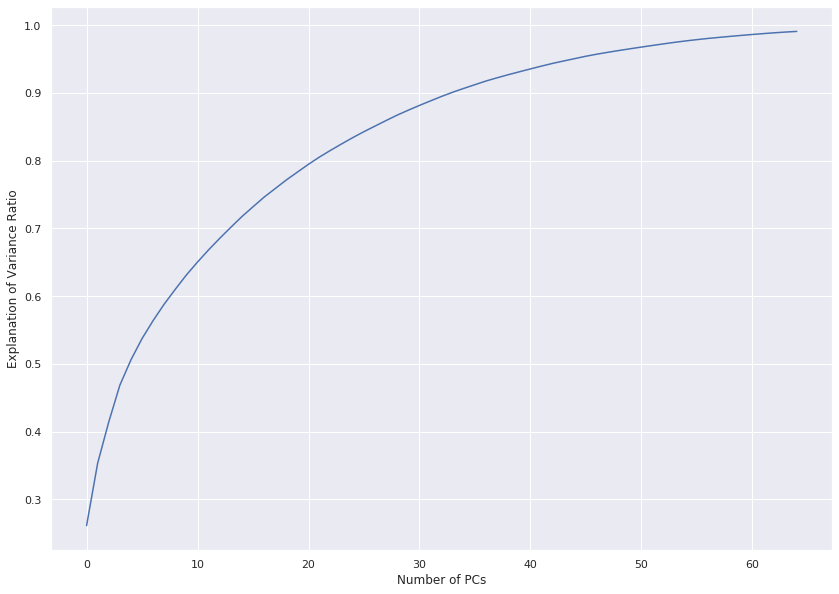

In [21]:
X_test_pca = pca.transform(X_test_scaled)
F = np.cumsum(pca.explained_variance_ratio_)

plt.figure()
plt.plot(F)
plt.xlabel('Number of PCs')
plt.ylabel('Explanation of Variance Ratio')
print('Number of principal components selected: ', len(pca.explained_variance_ratio_))

## Split data for training and validation

In [22]:
# Split into training and validation data
X_train_pca, X_val_pca, y_train, y_val = train_test_split(X_trainval_pca, y_trainval, test_size=0.2, random_state=0)

print('Number of training samples: %d'%len(y_train))
print('Number of validation samples: %d'%len(y_val))

# Create training, validation, and test data by adding label as the first column and removing headers
X_train_pca = pd.DataFrame.from_records(X_train_pca)
train_data = pd.concat([y_train.reset_index(drop=True), X_train_pca.reset_index(drop=True)], axis=1)

X_val_pca = pd.DataFrame.from_records(X_val_pca)
validation_data = pd.concat([y_val.reset_index(drop=True), X_val_pca.reset_index(drop=True)], axis=1)

X_test_pca = pd.DataFrame.from_records(X_test_pca)
test_data = pd.concat([y_test.reset_index(drop=True), X_test_pca.reset_index(drop=True)], axis=1)

Number of training samples: 76
Number of validation samples: 19


## Train model

In [ ]:
container = retrieve("xgboost", region=region, version='1.2-1')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/training-output'.format(bucket, prefix),
                                    sagemaker_session=sm_session)

xgb.set_hyperparameters(eta=0.1, objective='reg:logistic', num_round=10) 

# Save data
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)
test_data.to_csv('test.csv', header=False, index=False)

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')

s3_input_train = TrainingInput(s3_data='s3://{}/{}/train/train.csv'.format(bucket, prefix), 
                               content_type='text/csv')
s3_input_validation = TrainingInput(s3_data='s3://{}/{}/validation/validation.csv'.format(bucket, prefix), 
                                    content_type='text/csv')

# Train model
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

## Deploy model

In [ ]:
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge', serializer = CSVSerializer())

## Test model

In [ ]:
def predict(data, rows=500):
    l_class = []
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = xgb_predictor.predict(array).decode('utf-8')
        
        l_prob = predictions.split(',')
    
        for prob in l_prob:
            if (float(prob) >0.5):
                l_class.append(1)
            else:
                l_class.append(0)
    
    return l_class

y_predict = predict(test_data.to_numpy()[:,1:])

acc = accuracy_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict, average='weighted')
prec = precision_score(y_test, y_predict, average='weighted')
rec = recall_score(y_test, y_predict, average='weighted')

print('Accuracy: ', acc)
print('F1 score: ', f1)
print('Precision: ', prec)
print('Recall: ', rec)

Uncomment the next line to delete the endpoint and stop incurring cost.

In [ ]:
# xgb_predictor.delete_endpoint()